In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import sys
sys.path.append('../')
from src.processing import *
from src.visualization import *

from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import pickle

In [2]:
# Import artist and track data

tracks_raw = pd.read_csv('../../capstone1/spotify_data/tracks.csv')
artists_raw = pd.read_csv('../../capstone1/spotify_data/artists.csv')

In [3]:
### Explore artists

print('artists shape: {}'.format(artists_raw.shape))
print('columns: {}'.format(artists_raw.columns))

artists shape: (1104349, 5)
columns: Index(['id', 'followers', 'genres', 'name', 'popularity'], dtype='object')


In [3]:
# Copy and process raw artist and track data
artist_split = clean_artists(artists_raw)
tracks_split = clean_tracks(tracks_raw)

1104349 artists total
298616 artists with labeled genres
460843 genre-artist pairs after processing
586672 tracks total
574073 tracks with 3 or fewer artists
689217 track-artist pairs after processing


In [14]:
text = ", ".join(genre for genre in artist_split.genres)
text[:1000]

'carnaval cadiz, carnaval cadiz, carnaval cadiz, carnaval cadiz, classical harp, harp, classical contralto, british choir, "children\'s story", classic persian pop, persian traditional, desi pop, punjabi hip hop, punjabi pop, afro dancehall, afropop, azontobeats, nigerian hip hop, nigerian pop, filmi, indian folk, indian rock, kannada pop, indian fusion, desi pop, hindi indie, indian indie, indian rock, new delhi indie, sufi, russian electronic, swedish electropop, indian folk, khaliji, sheilat, desi pop, modern bollywood, afro dancehall, afropop, alte, nigerian pop, environmental, sleep, desi hip hop, tamil pop, opm, pinoy hip hop, pinoy r&b, pinoy trap, tagalog rap, kuduro, australian hip hop, australian trap, afropop, azontobeats, nigerian hip hop, nigerian pop, hindi indie, indian indie, indian singer-songwriter, pinoy hip hop, tagalog rap, uk drill, indie hidalguense, comedy, comic, haitian gospel, new comedy, vintage tango, folklore argentino, folklore argentino, villancicos, hou

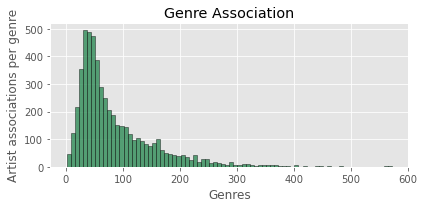

In [64]:
# Genre visualization

# masked_wordcloud(artist_split, mask = 'roam_4', min_font = 0.1, colormap_choice='Pastel2')
# masked_wordcloud(artist_split, mask = 'note', min_font = 8, colormap_choice='Pastel2')

# fig, ax = plt.subplots(figsize=(6,3))
# ax.hist(artist_split.genres.value_counts().values, color = 'seagreen', bins=80, alpha = 0.8, histtype='bar', ec='black')
# ax.set_xlabel('Genres')
# ax.set_ylabel('Artist associations per genre')
# plt.title('Genre Association')
# plt.tight_layout()
# plt.savefig('../img/genre_count_hist.png', dpi=300)

In [65]:
# Remove exceptionally rare genres

print('median number of arists per genre: {}'.format(artist_split['genres'].value_counts().quantile(0.5)))
top_50_genres, artist_50_genres = top_x_genres(artist_split, num_genres=50)
top_100_genres, artist_100_genres = top_x_genres(artist_split, num_genres=100)
top_200_genres, artist_200_genres = top_x_genres(artist_split, num_genres=200)

median number of arists per genre: 61.0


In [66]:
tracks_artists = artist_split.merge(tracks_split, on='id_artists')
tracks_artists_50 = artist_50_genres.merge(tracks_split, on='id_artists')
tracks_artists_100 = artist_100_genres.merge(tracks_split, on='id_artists')
tracks_artists_200 = artist_200_genres.merge(tracks_split, on='id_artists')

print('{} track-artist-genre combinations with all genres'.format(tracks_artists.shape[0]))
print('{} track-artist-genre combinations with 50 genres'.format(tracks_artists_50.shape[0]))
print('{} track-artist-genre combinations with 100 genres'.format(tracks_artists_100.shape[0]))
print('{} track-artist-genre combinations with 200 genres'.format(tracks_artists_200.shape[0]))

2077522 track-artist-genre combinations with all genres
302347 track-artist-genre combinations with 50 genres
554759 track-artist-genre combinations with 100 genres
777249 track-artist-genre combinations with 200 genres


In [72]:
# trim dataframe for dimensionality reduction
def track_features_and_labels(data):
    tracks_artists_clean = data[['genres','danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']]
    X, y = tracks_artists_clean.iloc[:, 1:], tracks_artists_clean.iloc[:, :1]
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    return X_train, X_test, y_train, y_test

X_train_50, X_test_50, y_train_50, y_test_50 = track_features_and_labels(tracks_artists_50)
X_train_200, X_test_200, y_train_200, y_test_200 = track_features_and_labels(tracks_artists_200)


(75587, 12)

In [73]:
rf_clf_50 = RandomForestClassifier()
rf_clf_50.fit(X_train_50, y_train_50)

rf_clf_200 = RandomForestClassifier()
rf_clf_200.fit(X_train_200, y_train_200)

# pickle.dump(rf_clf, open('../models/rf_clf.plk', 'wb'))

<ipython-input-73-34d509c32d79>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf.fit(X_train, y_train)


RandomForestClassifier()

In [ ]:
rf_pred_50 = rf_clf_50.predict(X_test_50)
print(classification_report(y_test_50, rf_pred_50))

rf_pred_200 = rf_clf_200.predict(X_test_200)
print(classification_report(y_test_200, rf_pred_200))

Error: Kernel is dead

In [ ]:
test = tracks_artists.iloc[31510]
track_genre_predictions(test, rf_clf_50)
track_genre_predictions(test, rf_clf_200)

Error: Kernel is dead

(0.0, 10.0)

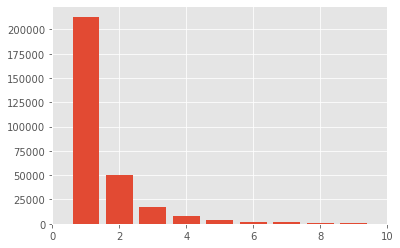

In [60]:
# Genre tags for each artist
genre_counts_per_artist = genre_df['genre_count'].value_counts()

fig, ax = plt.subplots()
ax.bar(genre_counts_per_artist.index, genre_counts_per_artist.values)
ax.set_xlim(0, 10)

count    5365.000000
mean       85.898043
std        71.625160
min         1.000000
25%        38.000000
50%        61.000000
75%       113.000000
max       572.000000
Name: genres, dtype: float64

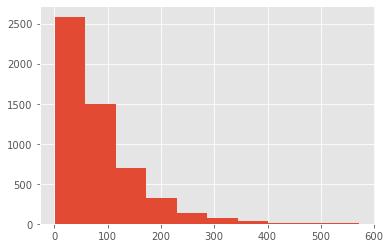

In [63]:
# Split genre tags for each artist

genre_counts = genre_split['genres'].value_counts()

fig, ax = plt.subplots()
ax.hist(genre_counts)
# ax.set_xlim(0, 10)
genre_counts.describe()